# Dimuon Spectrum

**Datasets:**
- https://opendata.cern.ch/record/12341


*Note: Download dataset and place into /workspace before running cells.*

## 1. Initialisation

### 1.1 Import necessary libraries

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from enum import Enum

### 1.2 Load dataset events tree

In [2]:
tree = uproot.open("Run2012BC_DoubleMuParked_Muons.root")["Events"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


### 1.3 Create pandas dataframe

In [3]:
num_rows = 1_000_000

df = tree.arrays(entry_start=0, entry_stop=min(tree.num_entries, num_rows), library="pd")
df

,nMuon,Muon_pt,Muon_eta,Muon_phi,Muon_mass,Muon_charge
0,2,"[10.763696670532227, 15.736522674560547]","[1.0668272972106934, -0.563786506652832]","[-0.03427272289991379, 2.5426154136657715]","[0.10565836727619171, 0.10565836727619171]","[-1, -1]"
1,2,"[10.538490295410156, 16.327096939086914]","[-0.42778006196022034, 0.34922507405281067]","[-0.2747921049594879, 2.539781332015991]","[0.10565836727619171, 0.10565836727619171]","[1, -1]"
2,1,[3.2753264904022217],[2.210855484008789],[-1.2234135866165161],[0.10565836727619171],[1]
3,4,"[11.429154396057129, 17.634033203125, 9.624728...","[-1.5882395505905151, -1.7511844635009766, -1....","[-2.0773041248321533, 0.25135836005210876, -2....","[0.10565836727619171, 0.10565836727619171, 0.1...","[1, 1, 1, 1]"
4,4,"[3.2834417819976807, 3.64400577545166, 32.9112...","[-2.1724836826324463, -2.18253493309021, -1.12...","[-2.3700082302093506, -2.3051390647888184, -0....","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, -1, 1, 1]"
...,...,...,...,...,...,...
999995,3,"[35.14982986450195, 53.28844451904297, 31.0205...","[1.1745023727416992, 0.17275173962116241, 1.17...","[1.4176057577133179, -1.5918025970458984, 1.41...","[0.10565836727619171, 0.10565836727619171, 0.1...","[1, -1, 1]"
999996,2,"[3.251176118850708, 21.20099639892578]","[-0.9367407560348511, -1.1522057056427002]","[1.0585579872131348, 1.1391607522964478]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"
999997,5,"[25.174882888793945, 6.868580341339111, 4.0572...","[-0.8478557467460632, -0.8894274830818176, -0....","[1.887718677520752, 1.9137606620788574, 1.7377...","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, 1, 1, -1, 1]"
999998,3,"[16.02674102783203, 25.430450439453125, 15.156...","[0.6424490213394165, 0.5862721800804138, 0.642...","[0.584553599357605, -2.885549306869507, 0.5847...","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, 1, -1]"


In [4]:
%%time

def calculate_momenergy(pt, eta, phi, **kwargs):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2)
    return {"px": px, "py": py, "pz": pz, "E": E}

def calculate_invariant_mass(E, px, py, pz, **kwargs):
    return np.sqrt(E**2 - px**2 - py**2 - pz**2)

combinations = []

for index, row in df.iterrows():
    if row["nMuon"] != 2:
        continue
    
    pt_array = row["Muon_pt"]
    eta_array = row["Muon_eta"]
    phi_array = row["Muon_phi"]
    charge_array = row["Muon_charge"]

    leptons = [
        {
            "pt": pt,
            "eta": eta,
            "phi": phi,
            "charge": charge,
        }
        for pt, eta, phi, charge in zip(
                pt_array,
                eta_array,
                phi_array,
                charge_array,
        )
    ]

    for lepton in leptons:
        momenergy_lepton = calculate_momenergy(**lepton)
        lepton |= momenergy_lepton

    momenergy_sum = {key: sum(lepton[key] for lepton in leptons) for key in leptons[0].keys()}
    invariant_mass = calculate_invariant_mass(**momenergy_sum)

    lepton_1 = leptons[0]
    lepton_2 = leptons[1]

    combination = {
        "mass": invariant_mass,

        "pt_1": lepton_1["pt"],
        "eta_1": lepton_1["eta"],
        "phi_1": lepton_1["phi"],
        "px_1": lepton_1["px"],
        "py_1": lepton_1["py"],
        "pz_1": lepton_1["pz"],
        "energy_1": lepton_1["E"],
        "charge_1": lepton_1["charge"],

        "pt_2": lepton_2["pt"],
        "eta_2": lepton_2["eta"],
        "phi_2": lepton_2["phi"],
        "px_2": lepton_2["px"],
        "py_2": lepton_2["py"],
        "pz_2": lepton_2["pz"],
        "energy_2": lepton_2["E"],
        "charge_2": lepton_2["charge"],
    }
    
    combinations.append(combination)

final_df = pd.DataFrame.from_dict(combinations)
final_df

CPU times: user 56.2 s, sys: 686 ms, total: 56.9 s
Wall time: 56.9 s


,mass,pt_1,eta_1,phi_1,px_1,py_1,pz_1,energy_1,charge_1,pt_2,eta_2,phi_2,px_2,py_2,pz_2,energy_2,charge_2
0,34.414819,10.763697,1.066827,-0.034273,10.757376,-0.368829,13.788543,17.492315,-1,15.736523,-0.563787,2.542615,-12.996994,8.872221,-9.349570,18.304442,-1
1,27.914656,10.538490,-0.427780,-0.274792,10.143103,-2.859586,-4.646915,11.517534,1,16.327097,0.349225,2.539781,-13.458614,9.243365,5.818438,17.332868,-1
2,113.646657,57.606701,-0.532089,-0.071798,57.458285,-4.132496,-32.118878,65.955700,-1,53.045078,-1.004169,3.089515,-52.973164,2.761204,-62.680396,82.113412,1
3,1.571812,11.319675,-0.771659,-2.245273,-7.069008,-8.841051,-9.627981,14.860453,1,23.906353,-0.700997,-2.180962,-13.698410,-19.592531,-18.164895,30.024609,-1
4,23.722246,10.193569,0.441807,0.677852,7.939991,6.392605,4.651537,11.204715,-1,14.204061,0.702117,-2.034401,-6.351703,-12.704771,10.812741,17.851350,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489468,1.141723,17.482302,0.147898,2.512468,-14.135190,10.287239,2.595037,17.673853,-1,10.734487,0.170655,2.592665,-9.157427,5.600958,1.840800,10.891177,1
489469,33.519415,22.609240,-1.237888,2.461476,-17.578671,14.218581,-35.703699,42.260286,1,11.685976,-0.265848,-1.587998,-0.201005,-11.684247,-3.143421,12.101369,-1
489470,34.367058,15.603183,0.029612,2.511177,-12.603975,9.197778,0.462115,15.610024,-1,17.261106,-0.589335,-0.731190,12.848830,-11.526203,-10.771726,20.346397,1
489471,1.913105,3.251176,-0.936741,1.058558,1.593497,2.833886,-3.510861,4.785007,-1,21.200996,-1.152206,1.139161,8.869584,19.256498,-30.203231,36.901455,1


## 2. Histogram

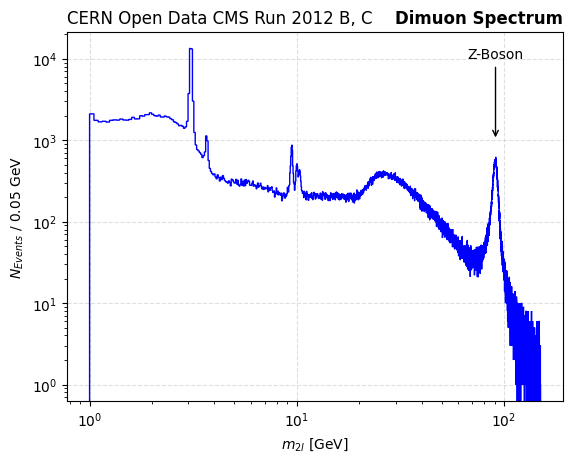

In [5]:
bins = 3000 
low = 1
up = 150.0  

plt.hist(final_df['mass'], bins=bins, range=(low, up), histtype='step', color='b')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('$m_{2l}$ [GeV]')
plt.ylabel('$N_{Events}$' + f' / {round((up - low)/bins, 2)} GeV')
plt.title('Dimuon Spectrum', loc="right", fontdict={"fontweight": 600})
plt.title('CERN Open Data CMS Run 2012 B, C', loc="left")
plt.grid(True, linestyle='--', alpha=0.4)
plt.annotate('Z-Boson', xy=(91, 10**3), xytext=(91, 10**4),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, ha='center')
plt.show()

## 3. Z-Boson events

In [6]:
final_df[round(final_df["mass"]) == 91].head(3)

,mass,pt_1,eta_1,phi_1,px_1,py_1,pz_1,energy_1,charge_1,pt_2,eta_2,phi_2,px_2,py_2,pz_2,energy_2,charge_2
22,91.271237,40.193432,1.685558,-0.124516,39.882251,-4.991797,104.706306,112.155796,1,54.995941,1.761236,-2.774224,-51.326364,-19.752414,155.302797,164.752883,-1
41,90.911858,25.716320,-0.916254,1.097718,11.717104,22.891889,-27.000770,37.287675,-1,16.935564,1.913920,-1.869911,-4.990471,-16.183588,56.159252,58.657266,1
73,90.935937,46.257011,1.635415,2.377910,-33.411176,31.990693,114.178881,123.193052,1,44.524792,1.336686,-1.038128,22.611202,-38.356103,78.891072,90.588400,-1
